![title](images/header.png)

# Ve - Supervised Classification with CAFI data - multiple models
-------
This notebook performed a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


# 1 - data preparation

## 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5e - with all the eSBAE columns

In [2]:
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,cnc_1520,CAFI_LC_2015,chg_prob,simple_combined,kmeans,plotid,lon,lat,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFtype,Ref_Ftype,Commentaires,collection,interpreted,Ref_LCtype,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,stratum,sampling
0,67,45,2020.137,1387.517090,1.123945,2017.288,0.010786,7937.461481,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,24.384312,61.561971,214.932292,-174.438721,0.0,0.0,196.0,1.0,73.0,7.0,22.0,54.0,35.252872,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,30.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.169508345861827 -2.39305080249901),76451,NaN,1,0.060000,0.060000,1,76451,10.169508,-2.393051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,systematic
1,70,42,2018.340,948.520996,2.265196,2016.348,0.437613,5604.878571,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,98.151968,25.593738,183.914615,11.354581,0.0,0.0,9.0,1.0,77.0,65.0,2.0,72.0,44.703648,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,37.0,31.0,11.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.17450939802276 -2.383416062692006),76452,NaN,1,0.019333,0.019333,1,76452,10.174509,-2.383416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,systematic
2,113,73,-1.000,0.000000,0.000000,2016.458,0.401874,8892.777626,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,39.203991,25.853591,121.616387,-55.887372,0.0,0.0,129.0,1.0,76.0,15.0,10.0,70.0,9.088154,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,74.0,21.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.173277074274033 -2.903386999146695),90643,NaN,13,0.215333,0.215333,2,90643,10.173277,-2.903387,90643.0,gmbombonda@gmail.com,False,2023-06-23 12:24,128.9 secs,POINT(10.173277 -2.903387),1.0,NaN,0.0,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,C,2.0,1,1.0,Stable,0.0,0.0,0.

In [3]:
len(ceo_esbae_1522)

222878

In [4]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Type_1522'],columns=['interpreted'],aggfunc="count")

Ref_Change_1522
NaN    215871
0.0      6718
1.0       289
Name: count, dtype: int64

In [5]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 
       'gfc_tc00','CAFI_LC_2015',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

### testing inclusion of phase I data (optional)

In [ ]:
#if you want to combine 2015-2020 data enter ISO to select country
#ceo_esbae_1520 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_merge.csv', delimiter=',')
#ceo_esbae_1520 = ceo_esbae_1520[ceo_esbae_1520['ISO'] == 'GAB']
#ceo_esbae_1520.head()

In [ ]:
#ceo_esbae_1520['Ref_Change_Year_1520'].value_counts()

In [ ]:
#ceo_esbae_1520['Ref_Change_Type_1520'].value_counts()

In [ ]:
#ceo_esbae_1520['Ref_Change_1520'].value_counts()

In [ ]:
#ceo_esbae_1520['interpreted'] = 1

In [ ]:
#len(ceo_esbae_1520)

In [ ]:
#all_ceo_esbae = pd.concat([ceo_esbae_1522, ceo_esbae_1520], ignore_index=True)
#all_ceo_esbae.head()

In [ ]:
#combine change column when using all ceo data
#all_ceo_esbae['Ref_Change'] = np.where((all_ceo_esbae['Ref_Change_1522'] == 1) | (all_ceo_esbae['Ref_Change_1520'] == 1), 1, 0)
#all_ceo_esbae['Ref_Change'].value_counts(dropna=False)

In [ ]:
#combine ref change year
# Fill NaN values in 'Ref_Change_1522' with values from the Ref_Change_1520
#all_ceo_esbae['Ref_Change_Ceo_Merge'] = all_ceo_esbae['Ref_Change_Year_1522'].fillna(all_ceo_esbae['Ref_Change_Year_1520'])
#all_ceo_esbae['Ref_Change_Ceo_Merge'].value_counts(dropna=False)

In [ ]:
#combine ref change year
# Fill NaN values in 'Ref_Change_1522' with values from the Ref_Change_1520
#all_ceo_esbae['Ref_Change_Type_Ceo_Merge'] = all_ceo_esbae['Ref_Change_Type_1522'].fillna(all_ceo_esbae['Ref_Change_Type_1520'])
#all_ceo_esbae['Ref_Change_Type_Ceo_Merge'].value_counts(dropna=False)

In [ ]:
#len(all_ceo_esbae)

In [ ]:
#all_ceo_esbae['Defall'].value_counts(dropna=False)

### select data set to proceed

In [6]:
# all ceo data from both phases - work in progress
# df = all_ceo_esbae
# only systematic ceo data
df = ceo_esbae_1522

In [7]:
all_ceo_cols = df.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope'

### 1.2 where/what are NAs
evaluate and replace no data values

In [8]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 355, 'dw_tree_prob__max': 355, 'dw_tree_prob__min': 355, 'dw_tree_prob__stdDev': 355, 'dw_tree_prob_mean': 355, 'elevation': 0, 'esa_lc20': 0, 'esa_lc21': 0, 'esri_lc17': 0, 'esri_

In [9]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 'potapov_tree_height','elevation','slope', 'tmf_2016', 
                   'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)


In [10]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [11]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_prob__min': 0, 'dw_tree_prob__stdDev': 0, 'dw_tree_prob_mean': 0, 'elevation': 0, 'esa_lc20': 0, 'esa_lc21': 0, 'esri_lc17': 0, 'esri_lc18': 0, 

In [12]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    214505
1.0      6718
0.0      1655
Name: count, dtype: int64

In [13]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

### 1.3 Run classification

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [14]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.7877702137823958


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

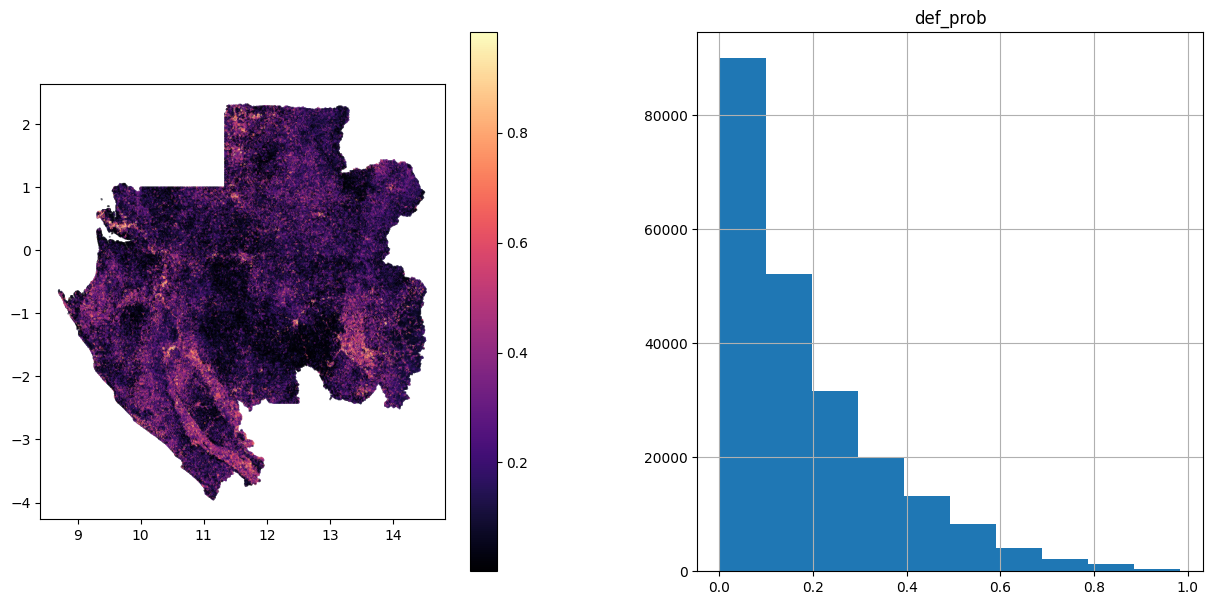

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [16]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.8209721724590947


array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

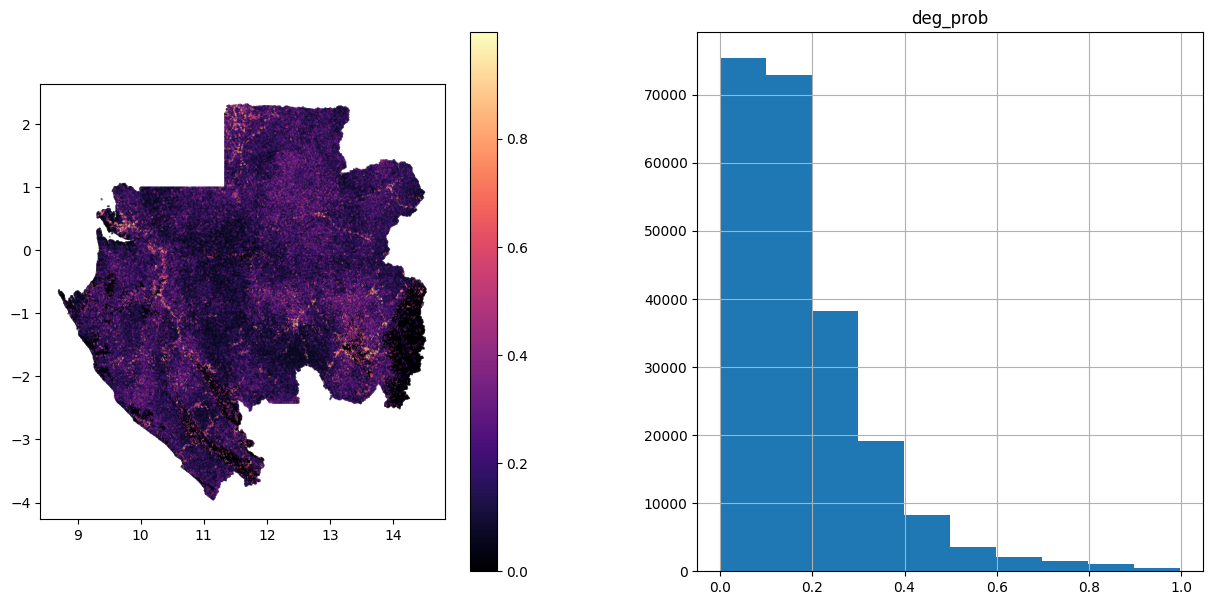

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [18]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.8846291651737729


array([<Axes: title={'center': 'stable_prob'}>], dtype=object)

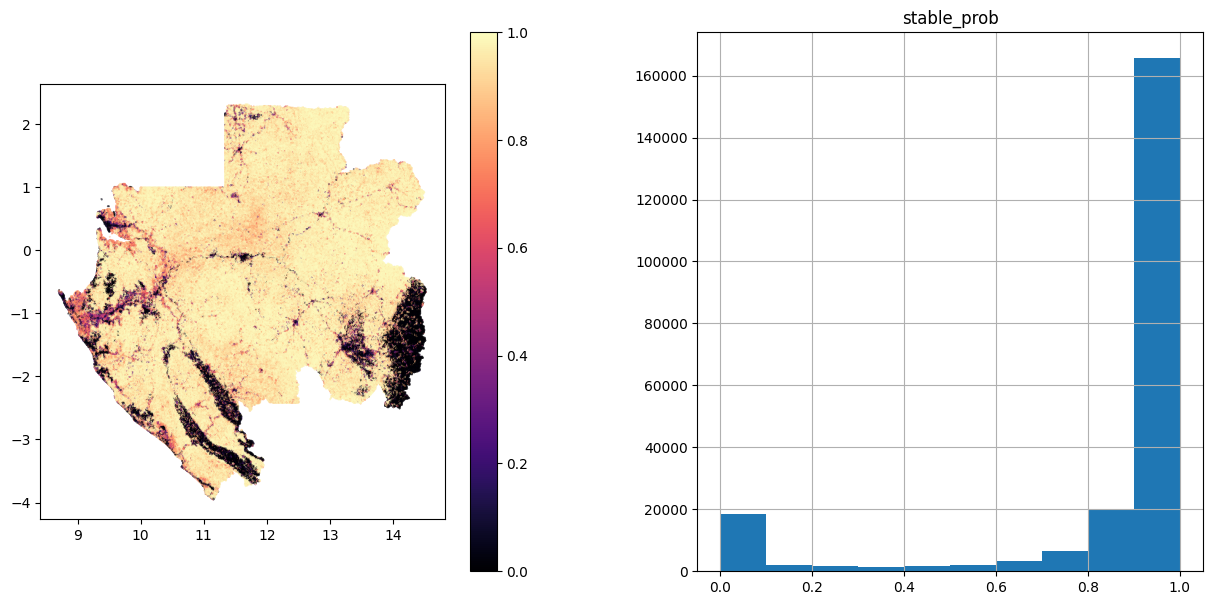

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [20]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.9073211513197181


array([<Axes: title={'center': 'nf_prob'}>], dtype=object)

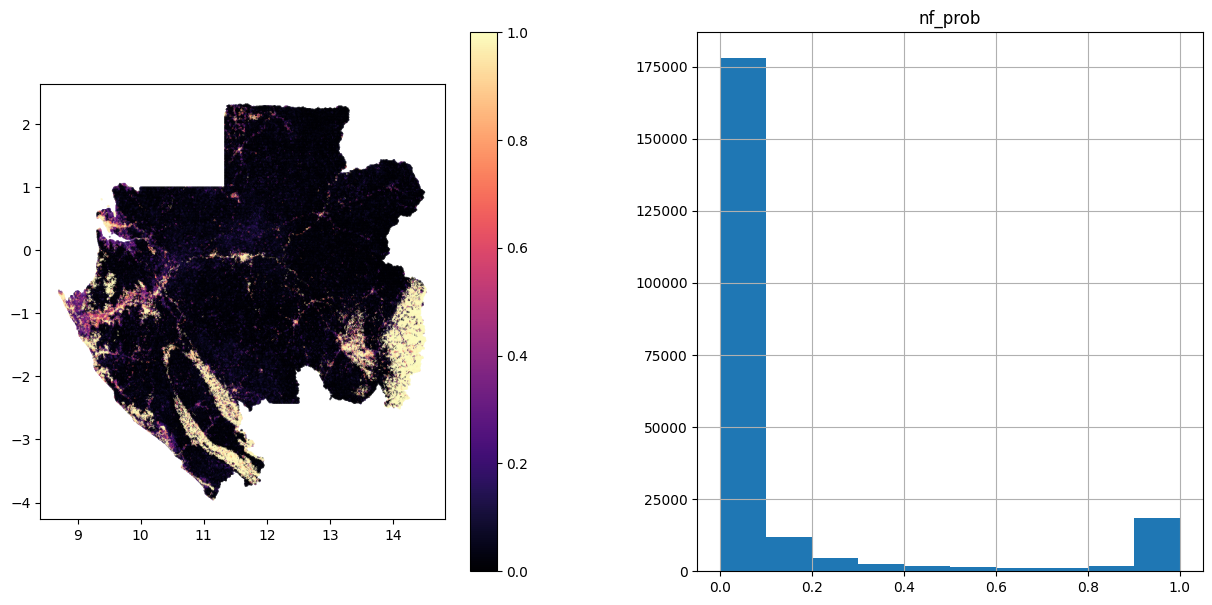

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [22]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

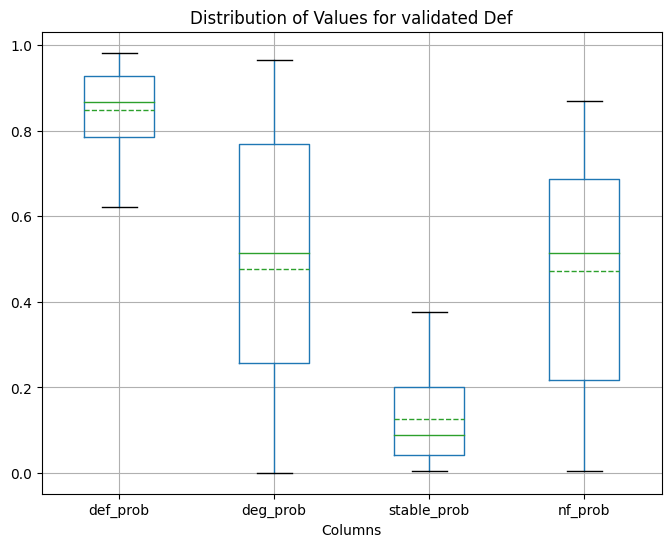

        def_prob   deg_prob  stable_prob    nf_prob
count  75.000000  75.000000    75.000000  75.000000
mean    0.849529   0.475680     0.125973   0.471618
std     0.089397   0.303119     0.106071   0.275579
min     0.621333   0.000667     0.005333   0.003333
25%     0.786000   0.257667     0.041667   0.217667
50%     0.866000   0.513333     0.089333   0.514667
75%     0.928667   0.769000     0.201667   0.688000
max     0.982667   0.964667     0.376000   0.868667


In [23]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

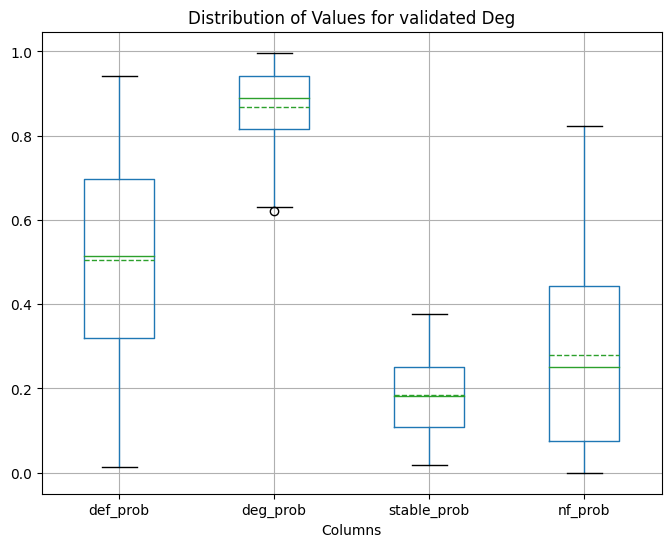

         def_prob    deg_prob  stable_prob     nf_prob
count  214.000000  214.000000   214.000000  214.000000
mean     0.504193    0.867333     0.183960    0.279044
std      0.250058    0.090082     0.090701    0.222304
min      0.014000    0.620000     0.018000    0.000000
25%      0.320000    0.817000     0.108000    0.074167
50%      0.514667    0.888667     0.182667    0.251333
75%      0.698000    0.941667     0.251167    0.442167
max      0.942667    0.997333     0.376000    0.822667


In [24]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

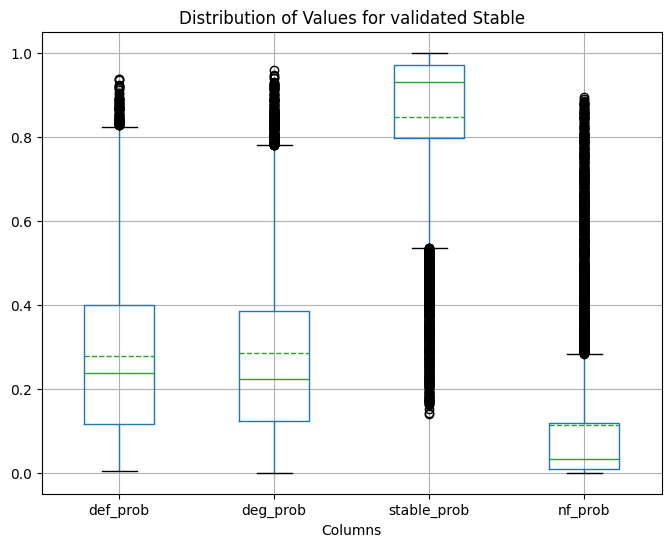

          def_prob     deg_prob  stable_prob      nf_prob
count  6718.000000  6718.000000  6718.000000  6718.000000
mean      0.277073     0.283678     0.847256     0.113706
std       0.199399     0.209201     0.185191     0.181434
min       0.002667     0.000000     0.140000     0.000000
25%       0.116833     0.122667     0.796000     0.009333
50%       0.237000     0.224000     0.929333     0.033333
75%       0.400000     0.385333     0.970000     0.118667
max       0.938000     0.958000     1.000000     0.894667


In [25]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

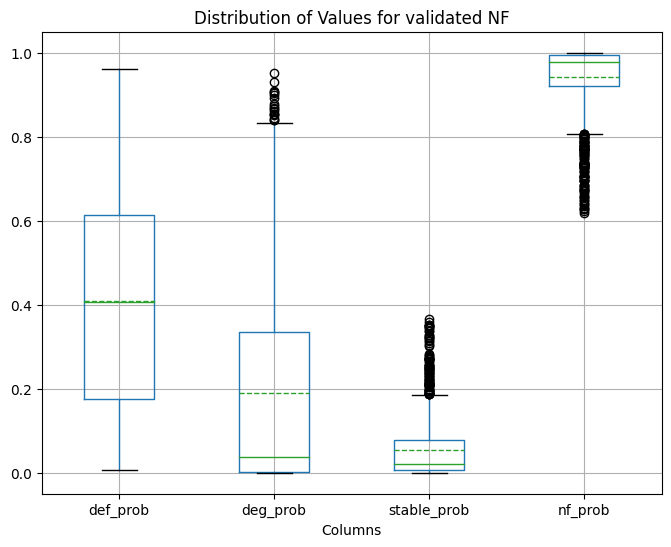

          def_prob     deg_prob  stable_prob      nf_prob
count  1366.000000  1366.000000  1366.000000  1366.000000
mean      0.409624     0.189818     0.054163     0.941115
std       0.250222     0.253166     0.071813     0.079475
min       0.007333     0.000000     0.000000     0.618667
25%       0.175667     0.001333     0.005333     0.919500
50%       0.407000     0.037333     0.021333     0.978333
75%       0.613833     0.335333     0.077333     0.995333
max       0.960000     0.952000     0.366667     1.000000


In [26]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [28]:
threshold = 0.8

In [29]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [30]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in this case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'stable'
    elif row['sim_deg'] >= 1:
        return 'deg'
    elif row['sim_def'] >= 1:
        return 'def'
    else:
        return 'nf'

# Apply the function to create a new 'classification' column
gdf['classification'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['classification'].value_counts(dropna=False)

classification
stable    185768
nf         34621
deg         1541
def          948
Name: count, dtype: int64

In [31]:
#enter country area (ha)
#GAB
study_area = 26287600
#DRC
#study_area = 232798200
#COG
#study_area = 34402400
#CMR
#study_area = 46497000
#EQG
#study_area = 2685800
#CAR
#study_area = 62009300

# Calculate the proportions and areas based on classified points
class_counts = gdf['classification'].value_counts()
percentage = (class_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': class_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

                Value Counts  Percentage of Total Rows     area
classification                                                 
stable                185768                        83 21910619
nf                     34621                        16  4083413
deg                     1541                         1   181755
def                      948                         0   111813


In [32]:
interpreted = gdf[gdf['interpreted'] == 1]

In [33]:
# Group by the selected columns and count occurrences
result_df = interpreted.groupby(['classification', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

   classification  Defall  Degall  Stable  NF  count
0             def       0       0       0   1     91
1             def       0       0       1   0     64
2             def       0       1       0   0      1
3             def       1       0       0   0     40
4             deg       0       0       0   1     33
5             deg       0       0       1   0    175
6             deg       0       1       0   0    170
7             deg       1       0       0   0     14
8              nf       0       0       0   1   1242
9              nf       0       0       1   0   1475
10             nf       0       1       0   0     43
11             nf       1       0       0   0     21
12         stable       0       0       1   0   5004


In [35]:
# Create a new column 'Count' based on the conditions to determine if points are in multiple classes
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

col_0   Count
Count        
0       15150
1      206737
2         925
3          66


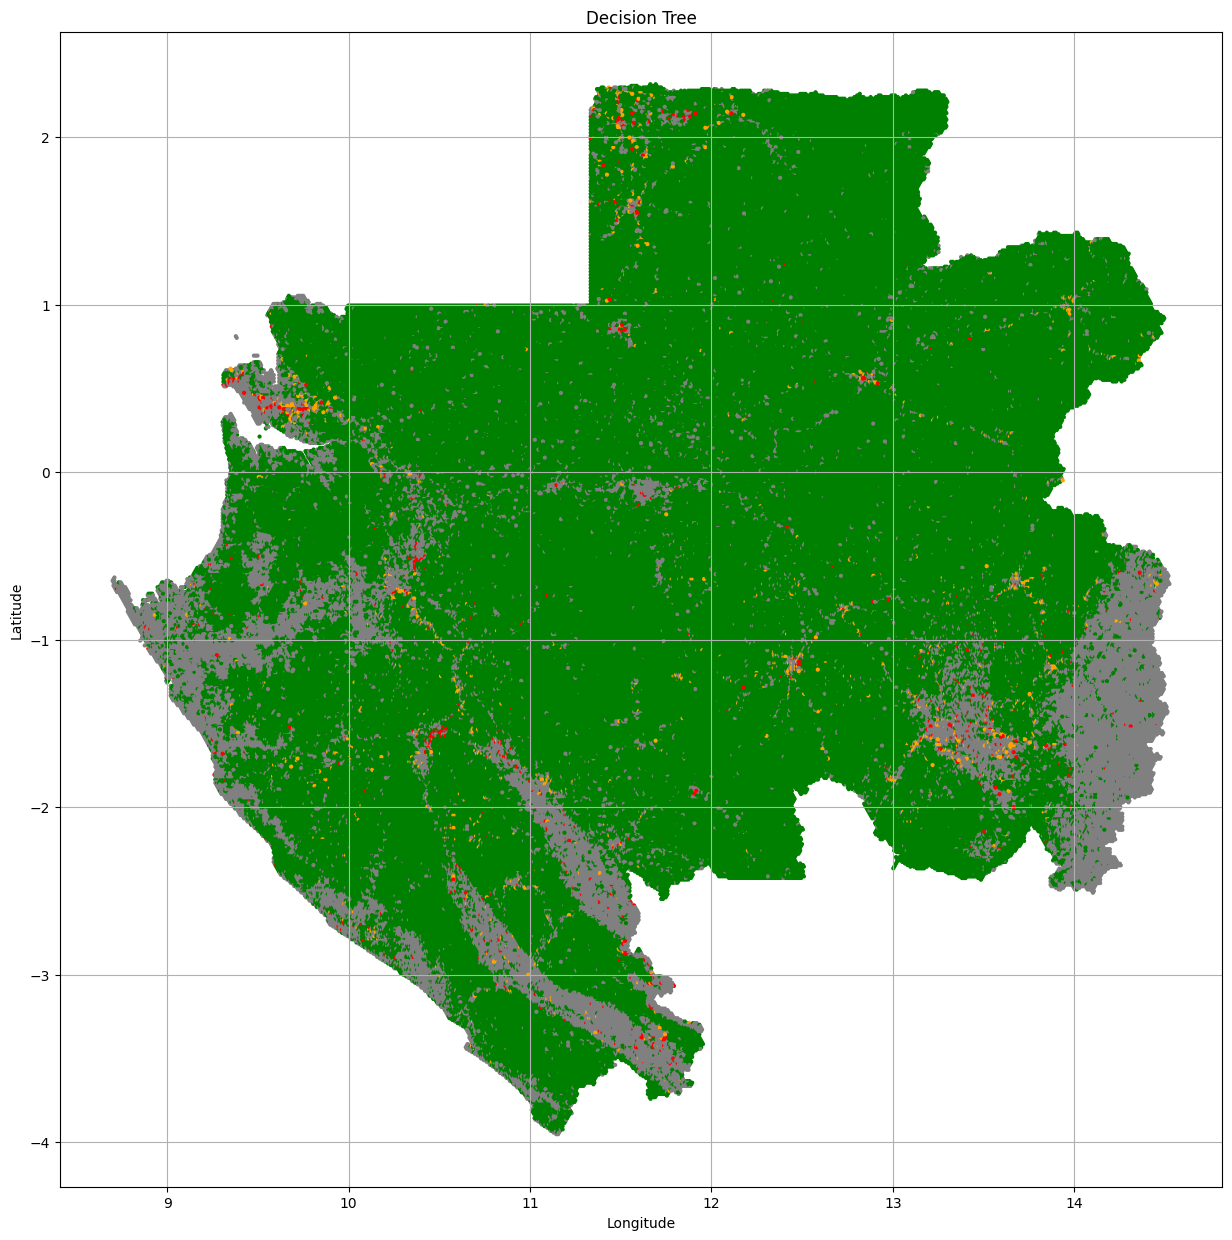

In [34]:
# plot point classes
category_colors = {
    'def': 'red',
    'deg': 'orange',
    'stable': 'green',
    'nf': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['classification'].map(category_colors), s=4)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Decision Tree')
plt.grid()
plt.show()

#### add years from cusum date

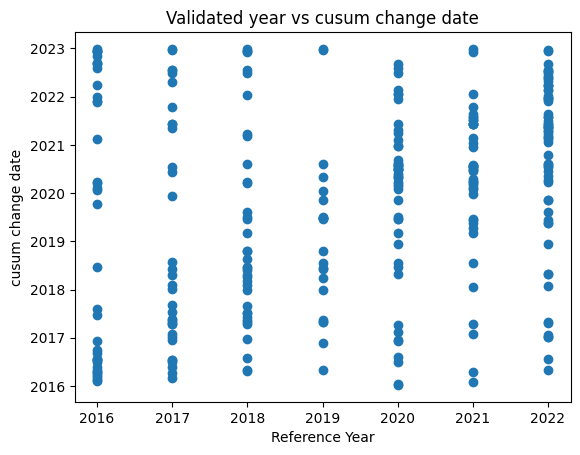

In [36]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

In [37]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)

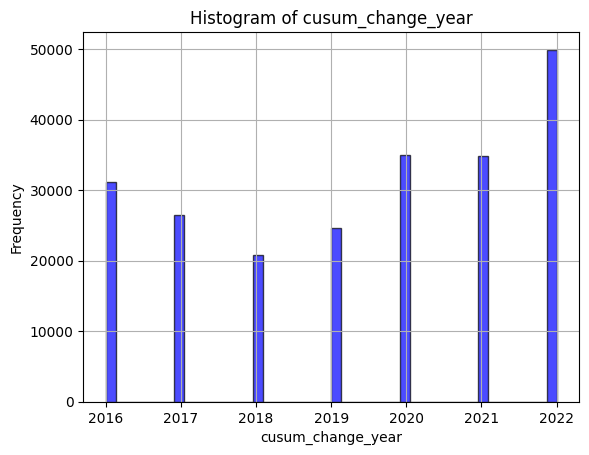

In [38]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [39]:
def y(x):
  if x['classification'] == 'def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x['classification'] == 'nf' : return 'NF'
  elif x['classification'] == 'stable' : return 'Stable'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

Sim_Ref_Change_Year_1522
Def2016       175
Def2017       107
Def2018       110
Def2019        94
Def2020       131
Def2021       134
Def2022       197
Deg2016       153
Deg2017       219
Deg2018       220
Deg2019       211
Deg2020       283
Deg2021       218
Deg2022       237
NF          34621
Stable     185768
Name: count, dtype: int64


In [40]:
#create hybrid column with values from interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf['classification'])

In [41]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

Sim_CEO_Ref_Change_Type_1522
stable    180764
nf         31840
Stable      6718
NF          1366
deg         1149
def          752
Deg          214
Def           75
Name: count, dtype: int64

In [42]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False)

Sim_CEO_Ref_Change_Year_1522
Stable     187482
NF          33206
Deg2020       250
Deg2022       213
Deg2018       202
Deg2017       190
Deg2019       189
Deg2021       184
Def2022       160
Def2016       160
Deg2016       135
Def2021       117
Def2020       107
Def2018       102
Def2017       100
Def2019        81
Name: count, dtype: int64

In [ ]:
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Type_1522'],columns=['interpreted'],aggfunc="count")

In [ ]:
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count")

#### plot data

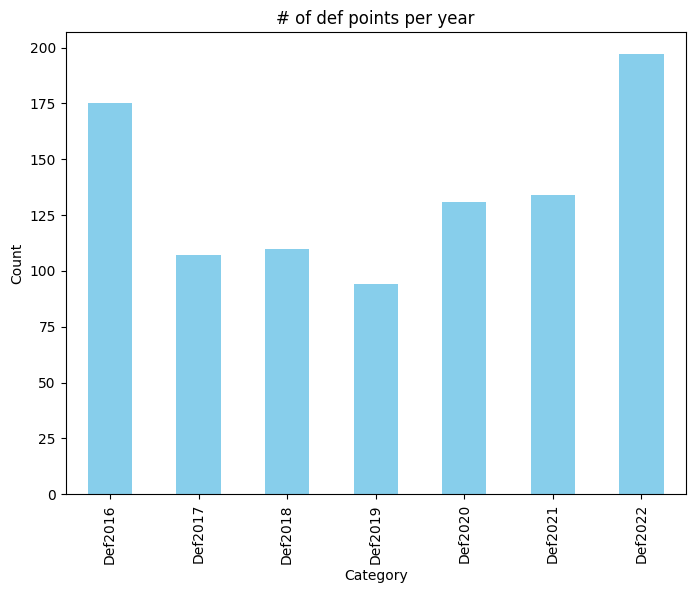

In [43]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

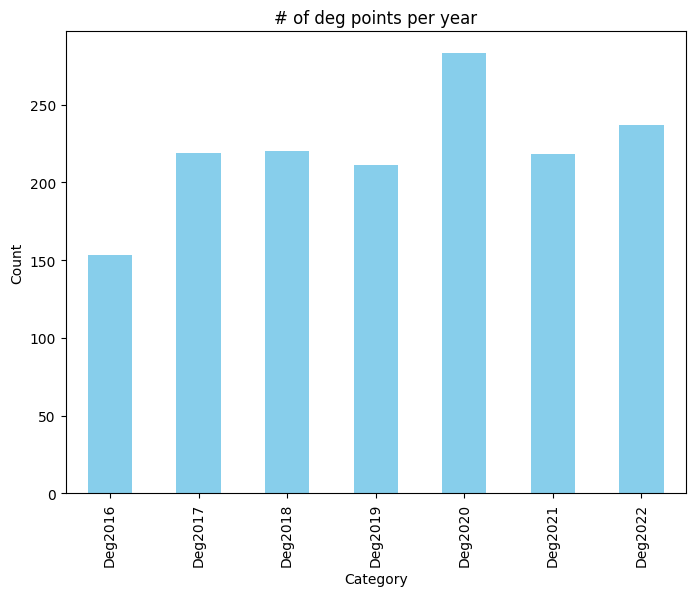

In [44]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [45]:
#export
out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv'
gdf.to_csv(out_file,index=True)

#### unbalanced RF - ***work in progress ignore for now***

In [ ]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_Ceo_Merge']

In [ ]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

In [ ]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

In [ ]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

In [ ]:
# Create an instance of the classifier
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

In [ ]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['balRF_pred'].map(category_colors), s=5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

In [ ]:
#get accuracies with replacement

In [ ]:
study_area = 26287600
# Calculate the proportions
value_counts = esbae_ceo['balRF_pred'].value_counts()
percentage = (value_counts / len(esbae_ceo)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)